# Physics 113: Problem Set 3

## Submit notebook to Canvas by Wednesday, June 5, 2024 11:59pm PDT

## Question 1: Quantum Chaos (10 points)

In this problem we will explore the quantum billiard system, which is a quantum mechanical analogue of the the classical dynamical billard system. In the classical version, the motion of a billard bouncing off a Bunimovich stadium boundary is known to be chaotic. A Bunimovich stadium is a rectangle with its corners rounded off into semicircles, similar to the shape of a running track. In the quantum mechanical analogue, we will explore the chaotic nature of the particle wave function trapped within a Bunimovich stadium-shaped potential.

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg

### 1A: Define Bunimovich Stadium Potential (2 points)

First we will set up our Bunimovich stadium shaped potential. Because the Bunimovich stadium is a rectangle with its corners replaced by semicircles, we can build it out of a rectangle with sides of length `L`, and semicircles with radius `R`.
The potential outside the stadium boundary is `V0` while the potential insde is 0. So our potential function is described by the following parameters:
* `x`: 1D array of the x axis on which the potential is defined. The array spans -R to R
* `y`: 1D array of the y axis on which the potential is defined. The array spans -L/2-R to L/2+R
* `R`: The radius of the semicircle
* `L`: The length of the rectangle
* `V0`: Potential outside the stadium boundary

In [268]:
# Implement stadium potential function.
def Vfun(x, y, R, L, V0):
    X, Y = np.meshgrid(x, y) # initialize grid

    # define function to characterize stadium shape
    def V(x, y):
        return 0 if (-L/2 <= y <= L/2) or (x**2 + (y - L/2)**2 <= R**2) or (x**2 + (y + L/2)**2 <= R**2) else V0
    
    # use vectorization to apply function to grid
    V = np.vectorize(V)(X, Y)
    return V

Plot your potential below and make sure you get what you expect

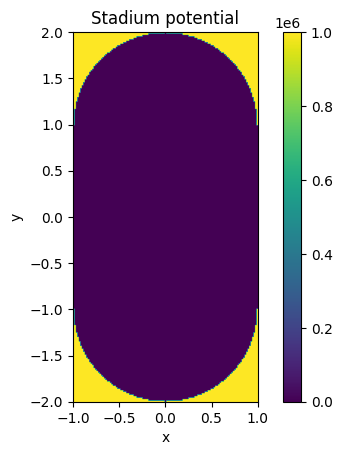

In [269]:
V0 = 1e6
R = 1
L = 2
Ny = 250
Nx = int(Ny * 2 * R / (2.0 * R + L))
ymin = -0.5 * L - R
ymax = 0.5 * L + R
xmin = -R
xmax = R
x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)

# use function to generate potential
V = Vfun(x, y, R, L, V0)

# plot the potential
plt.imshow(V, extent=[xmin, xmax, ymin, ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Stadium potential')
plt.colorbar()
plt.show()


✍🏽 Here we would've expected that inside the stadium, the potential is 0 and outside the potential is V0. Here we can tell with the stark color difference and colorbar to the right that this is in fact what we witness. 

### 1B: Set Up the Differential Equation: The 2D Schrodinger Equation (2 points)

The system is described by the two-dimensional time-independent Schrodinger's equation:
\begin{equation*}
H \psi= \left(-\frac{\hbar^2}{2m}\nabla^2 + V\right)\psi=E\psi
\end{equation*}
To solve it numerically, we need to discretize and explicitly express $\nabla^2$. Setting $\hbar=m=1$ for simplicity we arrive at this discretized form:
\begin{equation*}
-\frac{1}{2dxdy}\big[\psi_{n-1,m}+\psi_{n,m-1}-4\psi_{n,m}+\psi_{n+1,m}+\psi_{n,m+1}\big]+V_{n,m}\psi_{n,m}=E\psi_{n,m}
\end{equation*}
$\psi$ is now a 2D matrix with grid indices n and m. We can simplify the problem further by transforming $\psi$ into a 1D vector and turn the problem into a eigenvalue problem with 2D matrix H and 1D eigenvector solution $\psi$. This can be done by using the projection $nN+m\rightarrow n'$ to flatten the $\psi$ matrix, and we arrive at the equation:
\begin{equation*}
-\frac{1}{2dxdy}\big[\psi_{n'-N}+\psi_{n'-1}-4\psi_{n'}+\psi_{n'+1}+\psi_{n'+N}\big]+V_{n'}\psi_{n'}=E\psi_{n'}
\end{equation*}
From this equation we can define the 2D Hamiltonian matrx and solve for its eigenvalue and eigenvectors using a numerical solver. To speed up the computation, we use `scipy` sparse matrices instead of `numpy` arrays to encode the Hamiltonian matrix:

In [270]:
def schrodinger2D(x, y, V):
    Nx, Ny = len(x), len(y)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Create the 2D Hamiltonian matrix
    # First, the derivatives in the x direction.
    # Note that instead of using arrays, we use sparse matrices
    # in order to reduce computational resource consumption.
    Hx = sparse.lil_matrix(2 * np.eye(Nx))
    for i in range(Nx - 1):
        Hx[i, i + 1] = -1
        Hx[i + 1, i] = -1
    Hx = Hx / (dx ** 2)

    # Next, the derivatives in the y direction.
    Hy = sparse.lil_matrix(2 * np.eye(Ny))
    for i in range(Ny - 1):
        Hy[i, i + 1] = -1
        Hy[i + 1, i] = -1
    Hy = Hy / (dy ** 2)

    # Combine both x and y Hilbert spaces using Kronecker products.
    Ix = sparse.lil_matrix(np.eye(Nx))
    Iy = sparse.lil_matrix(np.eye(Ny))
    H = sparse.kron(Iy, Hx) + sparse.kron(Hy, Ix)

    # Re-convert to sparse matrix lil form.
    H = H.tolil()
    
    # And add the potential energy.
    for i in range(Nx * Ny):
        H[i, i] = H[i, i] + V[i]

    # Convert to sparse matrix csc form,
    return H.tocsc()

Use the `x`, `y` axis arrays and potential `V` defined before, we can compute the 2D Hamiltonian matrix `H` for our current setup. `matplotlib` has a convenient function `spy` for visualizing sparse matrices. Look up the documentation for `spy` to use it to visualize `H`. Comment on what the plot shows and why it justifies our use of sparse matrices to represent the Hamiltonian matrix instead of a numpy array

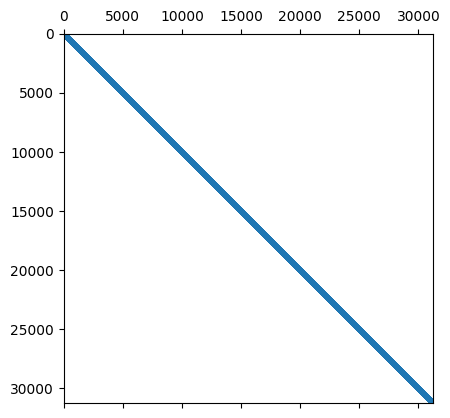

In [271]:
## Compute the 2D Hamiltonia matrix
H = schrodinger2D(x, y, V.flatten())

# visualize the sparse matrix with spy
plt.spy(H, precision = 0.01, markersize = 1) # ✍🏽
plt.show()

Comment on your results: ✍🏽 It makes sense to use spy for sparse matrices instead of numpy matricies because the solution matrix that we're considering has a large range, but a limited set of solutions. In the graph, we can tell that the area that our matrix must represent is large while the set of solutions exists within a narrow set. Some advantages of sparse matrices including more efficient memory representation and dot product functions compared to numpy representations. 

### 1C: Solving the 2D Schrodinger Equation (2 points)

To solve the 2D Schrodinger equation we just need to solve the eigenvalue problem
\begin{equation}
H\psi = E\psi
\end{equation}
where `H` is the sparse matrix we just computed. Look up the documentation for `scipy.sparse.linalg.eigs`, and use it to find six eigenenergies and wave functions around the value `E0=500`

In [272]:
## Solve the eigenvalue problem with linalg.eigs
nsol = 6
E0 = 500
eigen_val, eigen_vec = linalg.eigs(H, k = nsol, sigma = E0) # ✍🏽 taken from documentation

### 1D: Visualize the wave functions in a quantum chaos system (2 points)

Use the function defined below for you to visualize the wave function solutions. What does the color represent in these plots? How will the plots change if we use a much smaller V0?

Energy eigenvalues:
1: 497.57
2: 498.05
3: 499.68
4: 504.01
5: 505.71
6: 505.76


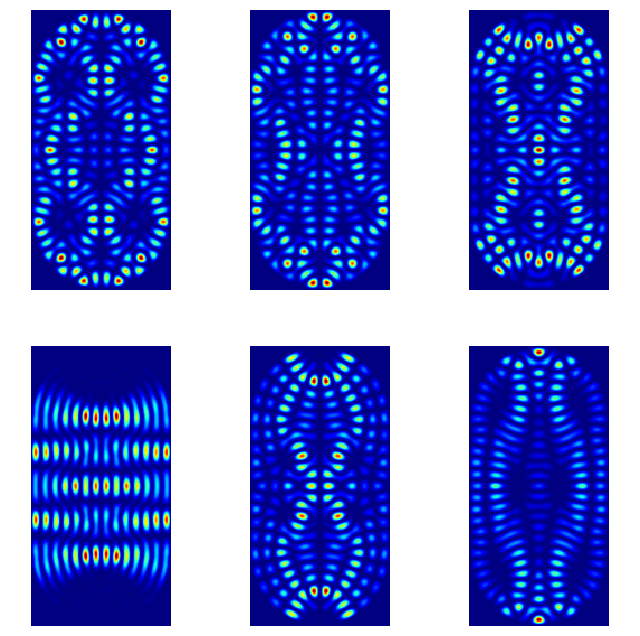

In [273]:
def plot_wavefunctions(eigen_val, eigen_vec):
    # Get eigen energies
    indices = np.argsort(eigen_val)
    print("Energy eigenvalues:")
    for i,j in enumerate(eigen_val[indices]):
        print("{}: {:.2f}".format(i + 1, np.real(j)))

    plt.figure(figsize = (8, 8))
    # Unpack the eigen vector into 2 dimensions for plotting:
    for n in range(nsol):
        psi = eigen_vec[:, n]
        psi2d = psi.reshape((Ny, Nx))
        psi2d = np.abs(psi2d)**2
        plt.subplot(2, int(nsol/2), n + 1)
        plt.pcolormesh(np.flipud(psi2d), cmap = 'jet')
        plt.axis('equal')
        plt.axis('off')
    plt.show()

## your code goes here
plot_wavefunctions(eigen_val, eigen_vec)

Comment on your results: ✍🏽 In these plots the color represents norm of the psi eigenvector solution, for each eigenvalue's wavefunction. Hence this plot allows us to visualize the 'solution' or the large eigenvector areas in the original wave functions. If we use a smaller potential energy difference between the well and the outside boundary then it becomes easier for the energy to escape and hence the definition of our solution becomes less clear. Hence the plots become more smooth and less defined. In other words, the intensity of the colors decreases because the background has more energy so our peak colors become more blue. 

These results are interesting for a couple of reasons. For one, the energy eigenvalues that we solved are in a very small band. This makes some sense because we're solving around the starting energy 500, but nonetheless intuitively I would've guessed there were less solutions and hence the ranges were larger. 

### 1E: Complexity of the Wave Functions (2 points)

The complexity of the wave functions can be thought of as the quantum analogue of the chaotic path taken by a billiard ball in a classical system. As we changes the energy of the system, the complexity of the wave functions changes accordingly. Re-solve the system with `E0=100` and `E0=1000`, keeping `nsol=6`. Plot the different solutions and comment on which one is more complex. Does it agree with your expectations?

Energy eigenvalues:
1: 95.22
2: 97.14
3: 100.87
4: 100.89
5: 103.53
6: 104.92


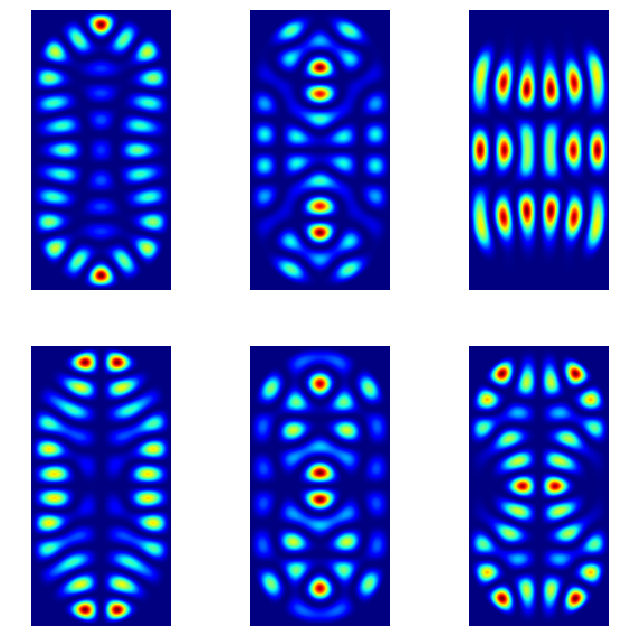

Energy eigenvalues:
1: 995.92
2: 996.28
3: 998.93
4: 1000.28
5: 1002.61
6: 1003.89


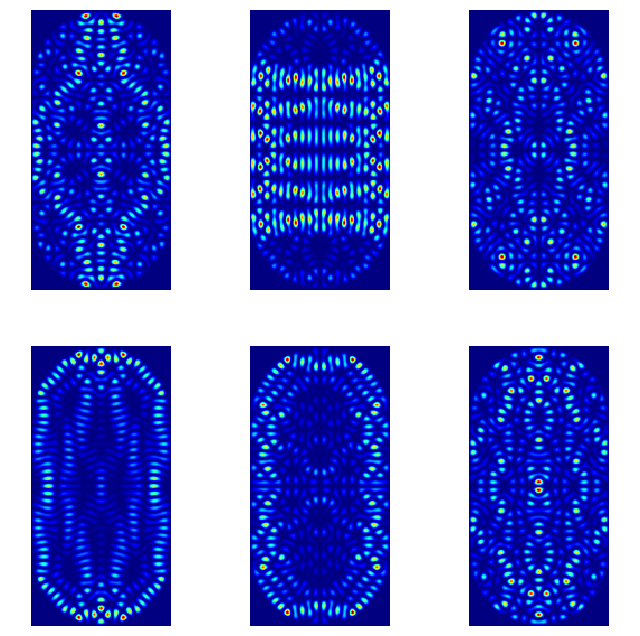

In [274]:
## your code goes here
eigen_val, eigen_vec = linalg.eigs(H, k = nsol, sigma = 100)
plot_wavefunctions(eigen_val, eigen_vec)
eigen_val, eigen_vec = linalg.eigs(H, k = nsol, sigma = 1000)
plot_wavefunctions(eigen_val, eigen_vec)

Comment on your results: ✍🏽 The most complex solution is the one that begins with the highest energy states. This is because the periodicity of the wavefunction is the smallest hence it appears the most complex. Compared to E0=10, E0=500 is significantly more complicated and similarly for E0=1000. 

## Question 2: Noise Filtering with the Fast Fourier Transform (10 points)

NASA's Apollo 11 mission just captured the historic moment the first moon landing, but oh no! The image appears to be covered in static. Scientists suspect that some noise must have been introduced as the photograph was sent from the Moon back to Earth. Can you use the Fast Fourier Transform to remove some of this noise?

In [275]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

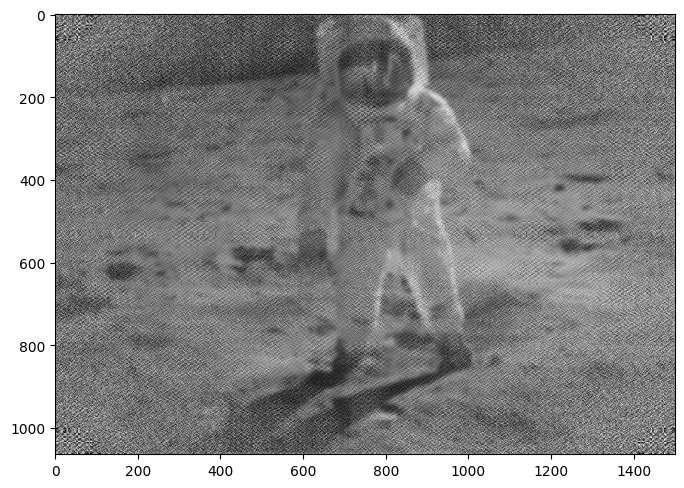

In [276]:
# Open image using openCV
im = cv2.imread('data/moon.png', cv2.IMREAD_GRAYSCALE)

# Show image as-is
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(im, cmap='gray')
plt.show()

Clearly this image is dull and covered in static. Perhaps we can learn more by taking an FFT?

### 2A: Fourier Transform the Noisy Image (2 points)

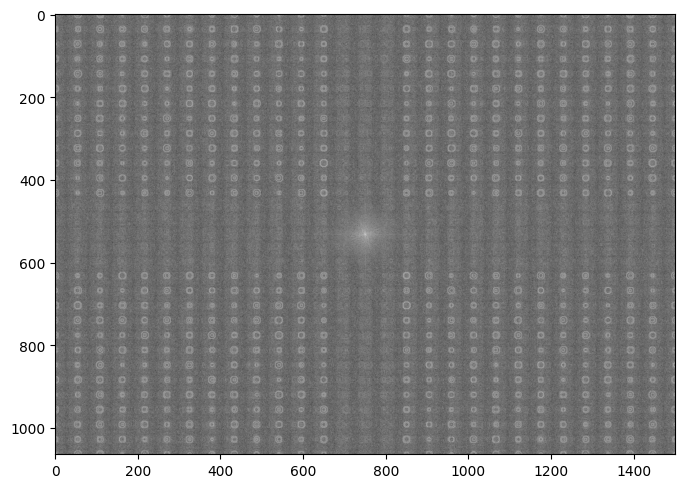

In [277]:
# Let's take the 2D FFT of the image
'''
    TO DO: Take a 2D FFT of the image using scipy
'''
fft = scipy.fft.fft2(im)

# Make sure to shift everything so high frequencies are in the center
#     and low frequencies are towards the edges (for simplicity)
'''
    TO DO: Shift the frequencies to center the highest ones using scipy
'''
fft = scipy.fft.fftshift(fft)

# Plot
# Let's use log scale since some frequencies are *very* high
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(np.abs(fft)), cmap='gray')

It looks like there are lots of dots all over the place. But luckily they're not as concentrated around the center. Trim these dots away by only keeping a relatively small number of frequencies around the center.

### 2B: Filter Image in Fouerier Space (2 points)

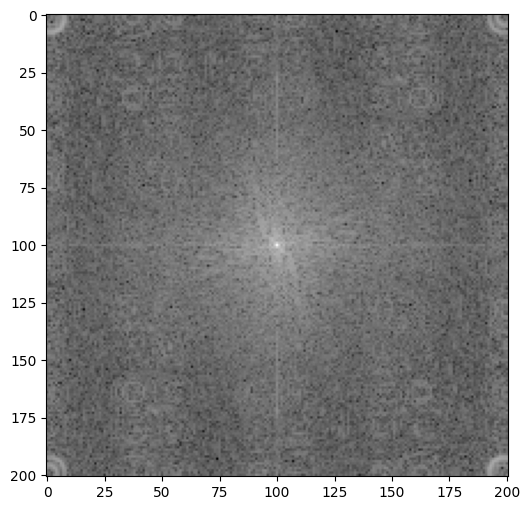

In [278]:
trimmed = fft.copy()
'''
    TO DO: Trim away some number of frequencies and re-plot the result.
'''
# let's get the center of the image
mid_width = int((trimmed.shape[0])/2)
mid_height = int((trimmed.shape[1])/2)
width = 100 # cut fixed width around center

trimmed = trimmed[mid_width-width:mid_width+width+1, mid_height-width:mid_height+width+1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(np.abs(trimmed)), cmap='gray')

Now use the cell below to check your work. How does the image look? You may have to try a few different values for the number of frequencies to trim away. The image won't look perfect, but it should certainly look better.

### 2C: Inverse Fourier Transform to Get Filtered Image (2 points)

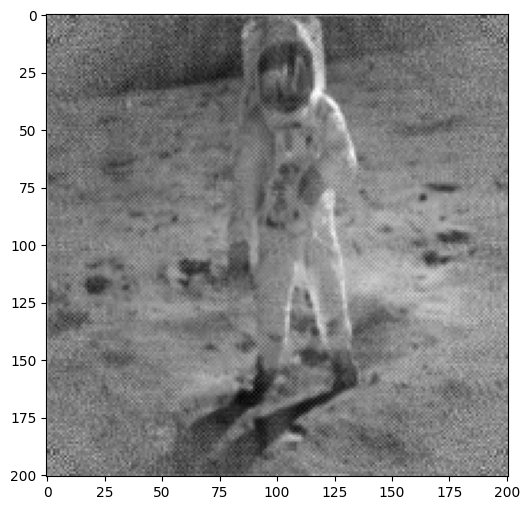

In [279]:
# Now we need to un-shift everything
'''
    TO DO: Unshift the frequencies to return the highest ones to the corners using scipy
'''
ifft = scipy.fft.ifftshift(trimmed)

# Let's inverse 2D FFT the image
'''
    TO DO: Take a 2D inverse FFT using scipy
'''
ifft = scipy.fft.ifft2(ifft)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(ifft.real, cmap='gray')

Besides the filtering of static noise, FFT filtering can be useful for removing all kinds of image artifacts as well. A common artifact in astronomical observations are stripping paterns due to the 'nodding' of the telescope as it scanns across the sky. Here is an example from radio telescope observation of the HI 21cm emission line:

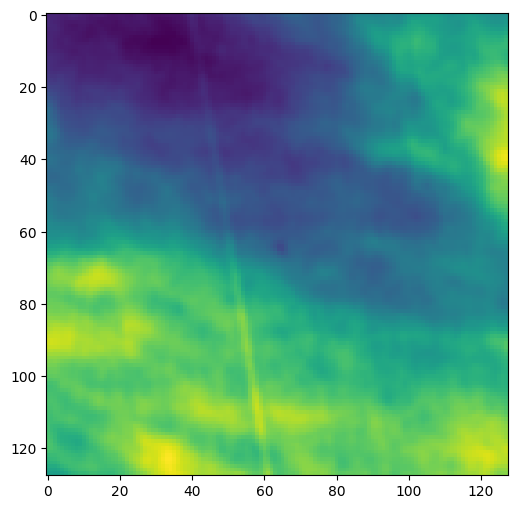

In [280]:
# Open image using openCV
im = np.load('data/stripe_noise_image.npy')

# Show image as-is
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(im)
plt.show()

### 2D: Stripe pattern in Fourier Space (2 points)

Apply the Fast Fourier Transform to the image, and identify the striping pattern

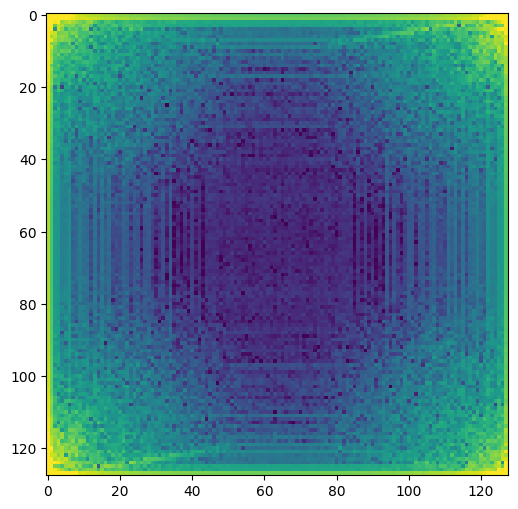

In [281]:
# Let's take the 2D FFT of the image
fft = scipy.fft.fft2(im)

# Plot
# Let's use log scale since some frequencies are *very* high
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.abs(fft), norm=LogNorm(vmin=1e18, vmax=1e22), origin="upper")
plt.show()

### 2E: Filter and remove the stripping pattern (2 points)

The stripe artifact shows up as a line with slope ~1/6 in the Fourier domain. Thus we can filter away the pattern by triming around that line within a certain width. Implement the trimming process and return the filtered image. Play around with the width of the area that you trim away to get the best result.

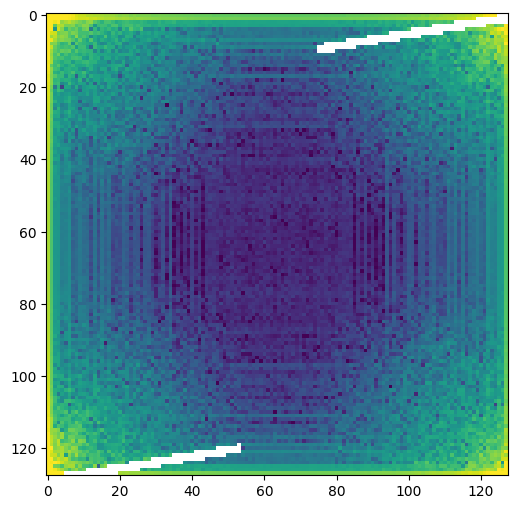

In [282]:
'''
    TO DO: Trim away the stripping pattern
'''
slope = 1/6
width = 0.007
trimmed = fft.copy()

# get center
im_height, im_width = trimmed.shape

# adjust intercept params to get two slices of noise stripe
intercept_lower = 129
intercept_upper = 22

# create grid to t/f mask
y, x = np.ogrid[:im_height, :im_width]
dist_lower = np.abs(y + slope * x - intercept_lower) / np.sqrt(1 + slope**2)
dist_upper = np.abs(y + slope * x - intercept_upper) / np.sqrt(1 + slope**2)

# create t/f array
lower_mask = np.logical_and(dist_lower < (width * np.sqrt(im_height**2 + im_width**2)), x < 50*im_width/120)
upper_mask = np.logical_and(dist_upper < (width * np.sqrt(im_height**2 + im_width**2)), x > 70*im_width/120)

# apply mask
trimmed[lower_mask] = 0
trimmed[upper_mask] = 0

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.abs(trimmed), norm=LogNorm(vmin=1e18, vmax=1e22), origin="upper")

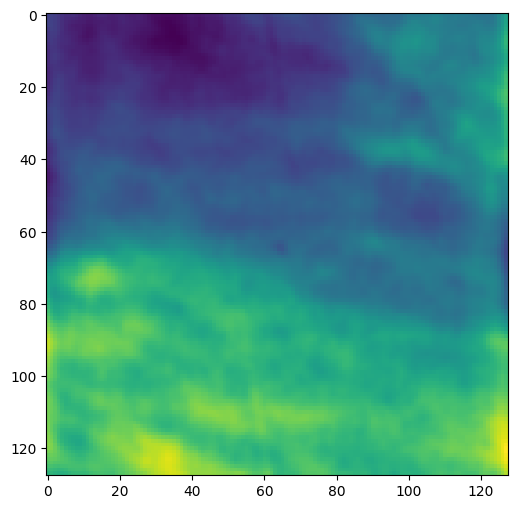

In [283]:
# Now we need to un-shift everything
'''
    TO DO: Unshift the frequencies to return the highest ones to the corners using scipy
'''
ifft = scipy.fft.ifftshift(trimmed)

# Let's inverse 2D FFT the image
'''
    TO DO: Take a 2D inverse FFT using scipy
'''
ifft = scipy.fft.ifft2(ifft)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.abs(ifft.real))
plt.show()

## Question 3: Stochastic Processes (10 points)

### 3A: Simple Random Walk (3 points)

Random walks are a fundamental concept in probability theory and have applications in various fields, such as physics, chemistry, and biology. A simple random walk on a lattice is a basic model for studying diffusion processes, where a particle moves randomly from one lattice site to a neighboring site.

In this part, you will simulate multiple random walks on a 2D square lattice and calculate the mean square displacement, which is a measure of how far the particles have traveled from their starting positions on average.

Write a Python function that simulates a simple random walk on a 2D square lattice. "Simple" in this case means that it begins at the origin $(0, 0)$ and at each timestep it moves one unit in either the $+x$, $+y$, $-x$, or $-y$ direction uniformly at random. The function should take the following parameters:

*   `steps`: The number of steps to be taken in the random walk.
*   `num_walks`: The number of random walks to simulate.

The function should return the entire set of trajectories, not just the final positions.

In [284]:
# your code here
def random_walk(steps, num_walks):
    traj = np.zeros((num_walks, steps, 2)) # initialize array with agents, steps, and x/y coordinates
    for step in range(1, steps): 
        for agent in range(num_walks):

            # randomly choose +x, -x, +y, -y via axis and change
            axis = np.random.choice([0, 1]) 
            change = np.random.choice([-1, 1])

            # update trajectory from previous step
            traj[agent, step, axis] = traj[agent, step - 1, axis] + change
    
    return traj

Plot the trajectories of the random walk for a few `num_walks`.

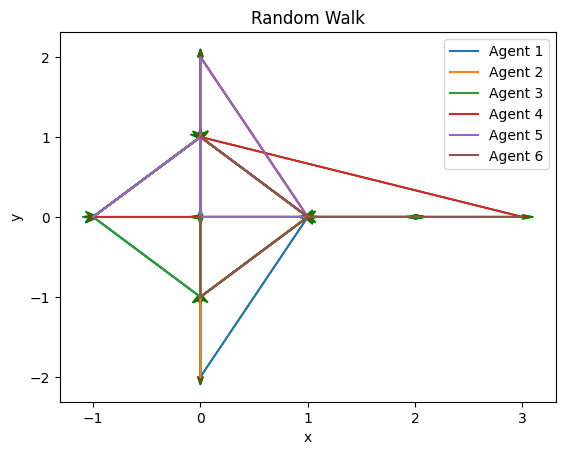

In [335]:
# your plot here
traj = random_walk(10, 10) # 10 agents, 10 steps

for agent in range(1, 7): # plot 3 agents
    plt.plot(traj[agent, :, 0], traj[agent, :, 1], label = 'Agent {}'.format(agent))
    
    # plot arrows 
    for step in range(9): # plot 9 steps
        plt.arrow(
            # xy from current step
            traj[agent, step, 0], 
            traj[agent, step, 1], 

            # xy from next step
            traj[agent, step + 1, 0] - traj[agent, step, 0], 
            traj[agent, step + 1, 1] - traj[agent, step, 1], 
            head_width=0.05, head_length=0.1, fc='red', ec='green')

# plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Random Walk')
plt.legend()
plt.show()

The square displacement of a single trajectory is $x_{\textrm{final}}^2 + y_{\textrm{final}}^2$, and the mean square displacement is this quantity averaged over many walks. How does the mean square displacement scale with the number of steps?

✍🏽 With the average number of steps, the mean displacement further approaches 0. We have an expectation that the placement of the agent will be 0 because we have equal prob of +/- x or y. However, the variance of the position is proportional to the square root of the number of steps and hence the mean square displacement is proportional to the square of the number of steps.

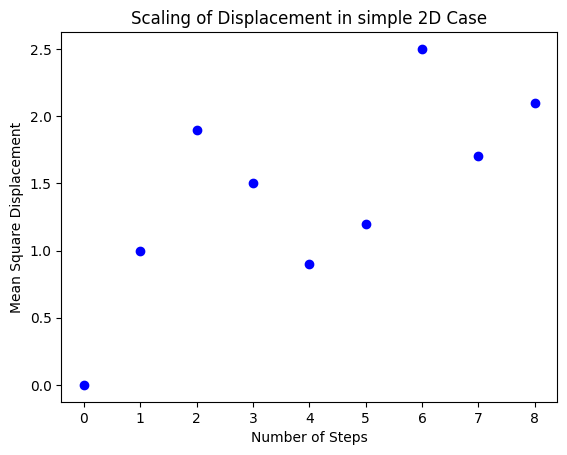

In [337]:
for step in range(9):
    mean_disp = np.mean(traj[:, step, 0]**2 + traj[:, step, 1]**2)
    plt.plot(step, mean_disp, 'bo')

plt.xlabel('Number of Steps')
plt.ylabel('Mean Square Displacement')
plt.title('Scaling of Displacement in simple 2D Case')
plt.show()

### 3B: Self-Avoiding Random Walk (3 points)

Self-avoiding random walks are a variant of random walks where the particle is not allowed to revisit any previously visited lattice site. This model is relevant in the study of polymer chains, where the monomers in the chain cannot overlap with each other due to steric hindrance.

Extend the function from part A to simulate a self-avoiding random walk on a 2D square lattice. A self-avoiding random walk is a random walk that does not revisit any previously visited lattice sites. The function should take an additional parameter:

*   `self_avoiding`: A boolean flag indicating whether the walk should be self-avoiding or not.

If `self_avoiding` is True, the function should ensure that the random walk does not revisit any previously visited lattice sites. Plot some trajectories of self-avoiding walks to ensure they are actually self-avoiding.

In [286]:
# your code here
def random_walk(steps, num_walks, self_avoiding = False):
    traj = np.zeros((num_walks, steps, 2))
    for step in range(1, steps):
        for agent in range(num_walks):

            # choose a random movement
            axis = np.random.choice([0, 1]) 
            change = np.random.choice([-1, 1])

            # self avoiding update
            if self_avoiding:
                while traj[agent, step - 1, axis] + change in traj[agent, :step, axis]:
                    # choose new movement if state is already visited
                    axis = np.random.choice([0, 1])
                    change = np.random.choice([-1, 1])

            # update trajectory
            traj[agent, step, axis] = traj[agent, step - 1, axis] + change
    
    return traj

Now plot the final positions of many random walks on a 2D scatter plot, with different colors or markers for self-avoiding and non-self-avoiding walks. Comment on the distribution.

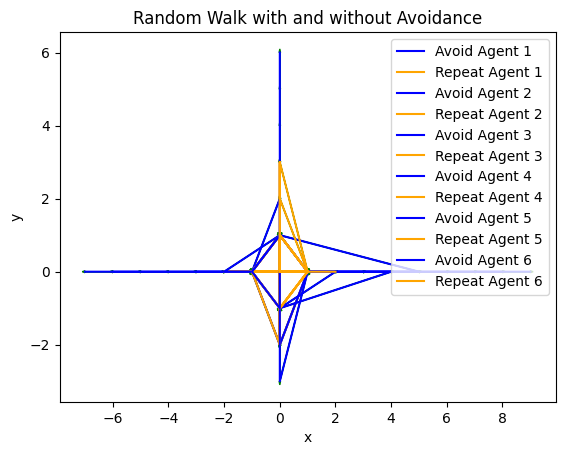

In [331]:
# your plot here
traj_avoid = random_walk(13, 7, self_avoiding=True)
traj_repeat = random_walk(13, 7, self_avoiding=False)

for agent in range(1, 7):

    plt.plot(traj_avoid[agent, :, 0], traj_avoid[agent, :, 1], label = 'Avoid Agent {}'.format(agent), color='blue')
    plt.plot(traj_repeat[agent, :, 0], traj_repeat[agent, :, 1], label = 'Repeat Agent {}'.format(agent), color='orange')
        
    for step in range(12):
        plt.arrow(traj_avoid[agent, step, 0], 
                  traj_avoid[agent, step, 1], 
                  traj_avoid[agent, step + 1, 0] - traj_avoid[agent, step, 0], 
                  traj_avoid[agent, step + 1, 1] - traj_avoid[agent, step, 1], 
                  head_width=0.05, head_length=0.1, fc='red', ec='green')
        
        plt.arrow(traj_repeat[agent, step, 0], 
                  traj_repeat[agent, step, 1], 
                  traj_repeat[agent, step + 1, 0] - traj_repeat[agent, step, 0], 
                  traj_repeat[agent, step + 1, 1] - traj_repeat[agent, step, 1], 
                  head_width=0.05, head_length=0.1, fc='red', ec='green')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Random Walk with and without Avoidance')
plt.legend()
plt.show()

✍🏽 I would've expected the distribution of the blue avoid agents to be generally more diverse or more spread out than the distribution of the repeat agents. However, it seems that while that might be true, they're still relatively similar in small total_steps cases. We can tell however that the blue agents do appear to cover more area than the orange which is probably because they take more unique paths than the orange agents. 

Is the scaling of the mean square displacement for the 2D self-avoiding walk the same as it was for the 2D simple random walk? Justify your answer with a plot or table of the mean square displacement versus the number of steps.

/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_80675/1459577845.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(step, mean_disp_avoid, 'bo', color='blue')
/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_80675/1459577845.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(step, mean_disp_repeat, 'bo', color='orange')


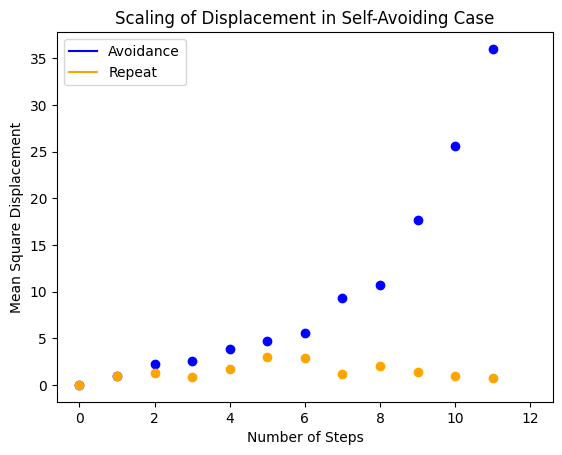

In [343]:
for step in range(12):
    mean_disp_avoid = np.mean(traj_avoid[:, step, 0]**2 + traj_avoid[:, step, 1]**2)
    plt.plot(step, mean_disp_avoid, 'bo', color='blue')
    mean_disp_repeat = np.mean(traj_repeat[:, step, 0]**2 + traj_repeat[:, step, 1]**2)
    plt.plot(step, mean_disp_repeat, 'bo', color='orange')

plt.plot(12, 0, "", color='blue', label='Avoidance')
plt.plot(12, 0, "", color='orange', label='Repeat')
plt.xlabel('Number of Steps')
plt.ylabel('Mean Square Displacement')
plt.title('Scaling of Displacement in Self-Avoiding Case')
plt.legend()
plt.show()

✍🏽 Through this visualization, we can clearly tell that there is an exponential or linear proportional growth between the number of steps and the mean square displacement. This confirms our hypothesis that the mean square displacement gorws according to the square of the number of steps. The divergence of the random walk and the self avoiding walk here makes it clear that the avoidance clearly creates a larger mean square displacement. 

### 3C: The Ornstein-Uhlenbeck Process and the Euler-Murayama Method (4 points)

We may write the simple random walk as $\vec{x}_{t + 1} = \vec{x}_t + \vec{\xi}$, for a random rectilinear unit vector $\vec{\xi}$. This equation can be thought of as the discretization of a continuous *stochastic* process. The full domain of stochastic differential equations, stochastic integrals, stochastic calculus, etc. is tricky because one must be careful with infinitesimals and orders of limits, but this problem will sidestep all that by remaining discrete with only hints of the underlying continuous process. As motivation, consider the motion of an object in 1D within a potential $V(x)$ and subjected to a linear velocity-dependent drag force $-b v$. Its equation of motion is $m a = -b v - V^\prime(x)$. In the overdamped case, the drag is much stronger than the potential, so we ignore $V(x)$. Defining $\gamma = \frac{b}{m}$, the resulting discretized equation is $\Delta v = -\gamma v \Delta t$. To this we can add a noise vector, as above, or add back the potential if we wish.

The **Ornstein-Uhlenbeck** process is a stochastic process represented discretely as:
$$ \Delta x = \left( \mu - x \right) \theta \Delta t + \sigma \Delta W. $$
The system relaxes to $x = \mu$, and $\theta$ controls the rate of this relaxation. $\sigma$ is the scale of the noise. $\Delta W$ is an increment from the *Wiener process*, a continuous analogue to a random walk where $W_{t + u} - W_t$ is normally distributed with mean 0 and variance $u$.

Because we are doing a single update at each timestep, this method is directly analogous to the Euler method, and is known as the **Euler-Murayama method**.

Implement the Euler-Murayama method for the Ornstein-Uhlenbeck process starting at $x(t = 0) = x_0$. Your function should take the following inputs:

*   `theta`, `mu`, and `sigma`: model parameters as noted above;
*   `x0`, `tf`, `N`: the initial condition is $x(t = 0) = x_0$, the time interval is $\left[0, t_f\right]$, and this interval should be divided so that there are $N$ Euler-Murayama steps;
*   `n_trajectories`: the number of trajectories to perform. Due to the randomness of $\Delta W$, each trajectory will result in a different trace for $x(t)$, unlike the deterministic ODEs and PDEs we have studied so far.

Take care that $\Delta W$ has the mean and variance stated above. Look into `numpy.random.Generator.normal` or `numpy.random.randn` for sampling random normals.

In [344]:
# your code here
def Euler_Murayama(theta, mu, sigma, x0, tf, N, n_trajectories):
    dt = tf / N # define dt
    X = np.zeros((n_trajectories, N + 1)) # initialize array for trajectories
    X[:, 0] = x0 # initial condiiton
    for i in range(n_trajectories):
        for j in range(1, N + 1):
            # for each update, add previous step + delta x equation above. mean = 0 and var = 1 on noise model
            X[i, j] = X[i, j - 1] + theta * (mu - X[i, j - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=np.sqrt(1))
    return X

Run your code for $\theta = 1$, $\mu = 1$, $\sigma = 0.2$, $x_0 = 0$, $t_f = 5$, $N = 1000$, and $\textrm{n\_trajectories} = 10$. Plot the resulting trajectories in $x$ versus $t$. How are they expected to look, and do they look this way?

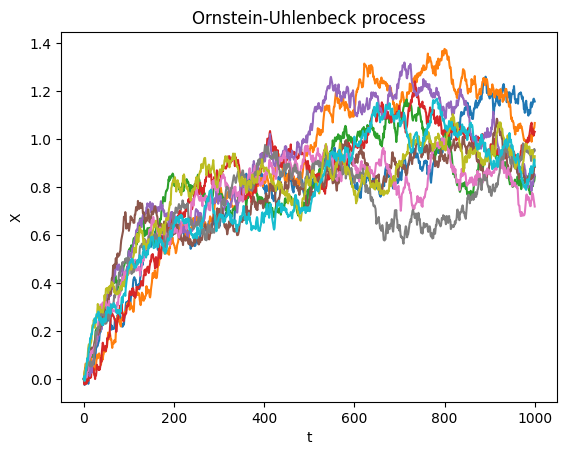

In [345]:
# your plot here
X = Euler_Murayama(1, 1, 0.2, 0, 5, 1000, 10)
for i in range(10):
    plt.plot(X[i, :])
plt.xlabel('t')
plt.ylabel('X')
plt.title('Ornstein-Uhlenbeck process')
plt.show()

✍🏽 This is what we expect it to look like hence it is correct. Breaking down each factor, we expect the system to relax to mu which is does at 1. We also expect that theta controls the rate of relaxation and we can assume this is working as we will test it. Because there is a bit of noise but nothing crazy, we can assume that the 0.2 number is working, most of the noise falls between 0.8 and 1.2 ish.  

Now run the code with all the same parameters except set $\sigma = 0.4$. Also, solve for analytical solution at $\sigma = 0$. Make a single plot that includes the 10 previous trajectories at $\sigma = 0.2$ all in one color, these new 10 trajectories at $\sigma = 0.4$ all in a second color, and the analytical solution at $\sigma = 0$ in black. This plot should illustrate the effect of $\sigma$.

✍🏽 Analytically, we know the solution is the following: 
$$ 0 = \Delta x = (\mu - x) \theta \Delta t + 0 = 0 $$
This only occurs when $x = \mu $, which is when $x = 1$ in this case. 

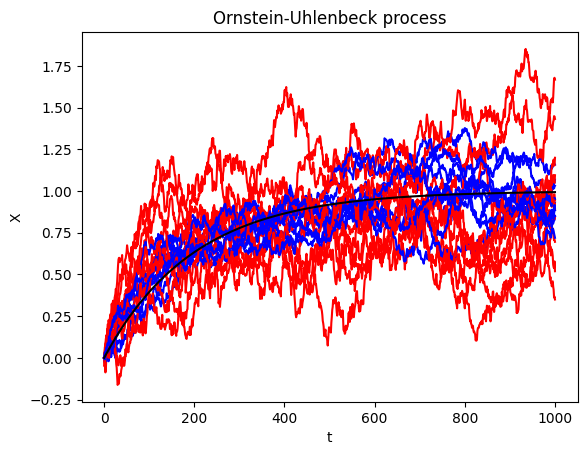

In [346]:
# your code/plot here
X_new = Euler_Murayama(1, 1, 0.4, 0, 5, 1000, 10)
Analytic = Euler_Murayama(1, 1, 0, 0, 5, 1000, 1)

for i in range(10):
    plt.plot(X_new[i, :], color = 'red')
    plt.plot(X[i, :], color = 'blue')

plt.plot(Analytic[0, :], color = 'black')
plt.xlabel('t')
plt.ylabel('X')
plt.title('Ornstein-Uhlenbeck process')
plt.show()


Feel free to make similar plots illustrating the effects of $\theta$, $\mu$, and $N$ for your own edification.

We are now interested in vertical slices through these plots. Run your code again for $\theta = \mu = 1$, $\sigma = 0.2$, $x_0 = 0$ but now with $t_f = 10$, $N = 500$, and $\textrm{n\_trajectories} = 1000$. This may be slow. **In a single plot**, plot histograms of the trajectories $x(t)$ for $t$ indices $i = 5, 10, 30, 50, 100, 200, 300, 400, 499$. (The time $t$ corresponding to an index $i$ should be $t = t_f*i / N$.) Make sure to set `histtype='step'` so that the bars are not filled. It is highly recommended to use a colormap to order the series.

Comment on this plot. In particular, how does the late-time behavior compare to that of the simple random walk?

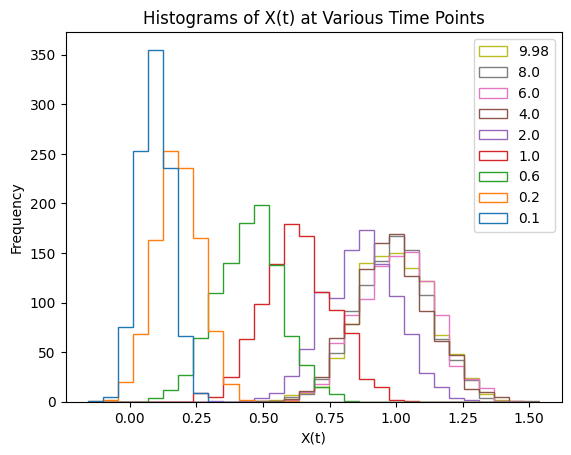

In [353]:
# your code here
X_full = Euler_Murayama(1, 1, 0.2, 0, 10, 500, 1000)

# create indices and times lists
indices = [5, 10, 30, 50, 100, 200, 300, 400, 499]
times = [10 * i / 500 for i in indices]

# plot histograms
plt.hist(X_full[:, indices], bins=30, histtype='step', label=times)
plt.xlabel('X(t)')
plt.ylabel('Frequency')
plt.title('Histograms of X(t) at Various Time Points')
plt.legend()
plt.show()

✍🏽 In the late time behavior we see that the distribution begins to converge. In this case, 4, 6, 8 and 10 seconds became roughly the same while the previous time steps had very different distributions, generally larger and more narrow. Compared to the simple random walk which we'd expect to remain around zero and have gaussian distribution, this appears to be a model that converges upon a gaussian ish model at the final point of X = 1. 

## Problem 4: The Metropolis-Hastings Algorithm and a Spin Glass

This problem will investigate the **Sherrington-Kirkpatrick model**, a common paradigm in the study of *spin glasses*, which are many-body spin systems where the interaction between spins is sign-changing and random, resulting in very slow (possibly arrested) dynamics and low-energy states that lack the regularity of a crystal, much in the same manner as structural glass. Spin glasses were historically one of, if not the first disordered systems to permit analytical solutions, and they provide an interesting link between physics, complex systems, computational complexity theory, and information theory.

In the original Sherrington-Kirkpatrick model, the spins are *Ising* spins: they may take value $+1$ or $-1$. There are $N$ such spins represented in a vector $s$. Unlike more standard Ising models where spins are only coupled to their nearest neighbors, the Sherrington-Kirkpatrick model is an all-to-all model: the spin $s[i]$ is coupled to the spin $s[j]$ via the matrix element $J_{ij}$. And because the model is representing a disordered system, the $J_{ij}$ are drawn from an ensemble. Typically one uses a normal distribution, rescaled so that the total energy is linear in $N$ (i.e. properly extensive). In symbols, the energy of a spin configuration is:
$$ E(s) = -\frac{1}{2} \sum_{i, j} J_{ij} s[i] s[j]. $$
The $J_{ij}$ are symmetric and normally distributed with variance $1 / N$ and mean $\mu / N$, and we set $J_{ii} = 0$. This energy is often written $-\sum_{i < j} J_{ij} s[i] s[j]$, which is equivalent to the above under the stated conditions. Note that for $\mu \gg 1$, essentially all the $J_{ij}$ are positive, so the low energy configuration have the spins aligning with each other as in a ferromagnet. But we are interested in the small-$\mu$ case.

### 4A: Preliminaries and Markov Chain Sampling (3 points)

As you may know, all the thermodynamics of an isolated system follow the *Boltzmann distribution*, where the probability of a configuration is proportional to its Boltzmann weight: $\mathrm{Pr}(\mathcal{C}) \propto \exp\left[-E(\mathcal{C}) / k_B T \right]$. The normalization factor is the sum of all of these, termed the *partition function* $Z = \sum_\mathcal{C} \exp\left[-E(\mathcal{C}) / k_B T \right]$. $Z$ is far more than just a normalization constant, however: its derivatives contain all the expectation values of state functions of the system, such as energy. Since we are interested in thermal averages of observables $\mathcal{O}$, we seek weighted averages of the form:
$$ \left< \mathcal{O} \right> = \sum_{\mathcal{C}} \mathcal{O}(\mathcal{C}) \mathrm{Pr}(\mathcal{C}) = \frac{1}{Z} \sum_{\mathcal{C}} \mathcal{O}(\mathcal{C}) \exp\left[-E(\mathcal{C}) / k_B T \right].$$

If we could perform this average, we would be done! So, let us return to the spin glass. With $N = 30$ Ising spins, what is the total number of possible spin configurations $\mathcal{C}$?

✍🏽 Total number of spin configurations over 30 possible spins is 2^30 because each spin could be +/-. Hence 2^30 ~ 10e9.

While this is not impossible to loop over, it is a bit too many states for our purposes, and we would be stuck if we wanted to examine $N = 50$. So we need a different way to sample among configurations. Many different techniques have been developed for sampling problems like this, but the workhorse that all students learn is the **Metropolis-Hastings algorithm**. Rather than provide exact values for all the weights, instead this algorithm traipses through configurations $\mathcal{C}$ such that it spends an amount of time in a configuration roughly proportional to $\mathrm{Pr}(\mathcal{C})$. It does this by using transition rules that result in a *Markov process* (a process where the only thing determining where to go next is where one is now) whose late-time stationary distribution is the desired probability distribution. This is a discrete stochastic process, so one must rely on randomness as in problem 3; this gives it the Monte Carlo label. Overall, the Metropolis-Hastings is a *Markov Chain Monte Carlo* (MCMC) sampling method.

In pseudocode, the Metropolis-Hastings is brief:
1. Sample the current configuration $\mathcal{C}$. Randomly propose a change to a new configuration $\mathcal{C}^\prime$.
1. Calculate the energy difference of the change: $\Delta E = E\left(\mathcal{C}^\prime\right) - E(\mathcal{C})$. Based on $\Delta E$:
    * If $\Delta E \leq 0$, accept the change and update the current configuration to $\mathcal{C}^\prime$.
    * If $\Delta E > 0$, draw a number $x$ uniformly at random from $[0, 1]$. If $x < \exp\left(-\Delta E / k_B T\right)$, accept the change and update the current configuration to $\mathcal{C}^\prime$. Otherwise, reject the change and stay in configuration $\mathcal{C}$.


Ensure that you understand what this does in the limit of high and low temperatures. One must still run the Markov chain a long time before the trajectory approaches the stationary distribution, particularly in ordered low-temperature phases. So one must be very efficient. In our basic implementation, the proposed changes will be single spin flips, so we need to efficiently calculate $\Delta E$ from a given configuration $s$ to a new configuration $s^\prime$ where the spin at position $k$ has been flipped.

Analytically simplify the expression for $\Delta E = E\left(s\textrm{ with spin at }k\textrm{ flipped}\right) - E(s)$. As a hint, divide the sum into terms where $i, j$ are equal or not equal to $k$.

Once you have done this, implement the function `DeltaE` below. As noted, it takes:
* `s`, the current vector of spins;
* `k`, the index of the proposed flip; and
* `Jij`, the coupling matrix.

It should return the energy difference, with the following two stipulations:
1. **It cannot loop over or use the whole matrix $J_{ij}$.** That is, the total number of elements read/written in the function cannot scale as $N^2$.
2. **It cannot use any `for` loops!** Use numpy's vector operations if you need them. (Hint: you will need them.)

✍🏽 My analytic simplication is below, I worked to cross out common terms and use index notation to recognize when values were expected to be the same and hence their difference was expected to be 0. I assume here we're given $k$ because $k$ is a random index that we generate. Hence I don't iterate over $k$ even though we would produce many random indexes $k$. 
$$ \Delta E = \sum_{i} J_{ik} (2 * s[i] * \text{sign}(s[k])) $$

In [354]:
def DeltaE(s, k, Jij):
    return 2 * np.sum(Jij[:][k] * np.sign(s[k]) * s[:])

### 4B: Order Parameters and the Metropolis-Hastings Algorithm (4 points)

We know how to do Metropolis-Hastings steps, but we now need observables $\mathcal{O}$ to actually sample! In most Ising systems, an order parameter of interest is the average magnetization $m$, defined as:
$$ m(s) = \frac{1}{N} \sum_{i} s[i]. $$
In a ferromagnet, one expects the thermal distribution of $m$ to be peaked near $m = \pm 1$, while in a disordered phase or paramagnet one expects the distribution to be peaked near $m = 0$. Note that for $N$ spins, this value must lie between $-1$ and $+1$, and it can only take on $N + 1$ values total, namely $\frac{1}{N} \{-N, -N + 2, \ldots, +N\}$.

But what about a glass? The sign changes in $J_{ij}$ mean that the low-energy states that are well-populated in the thermal distribution could have an average magnetization near zero. So how does one distinguish glassy behavior from paramagnetic behavior? This is done with the notion of an *overlap*: the hallmark of glassiness is that the system gets stuck in energy minima, rather than sampling a very large number of states the way a paramagnet does. So if one has two spin systems subjected to the same $J_{ij}$, in a glass phase the two systems would often end up in similar or anti-aligned configurations, while in a paramagnetic phase the two systems would not show any correlation at all. So one defines the overlap $q$:
$$ q\left(s_1, s_2 \right) = \frac{1}{N} \sum_i s_1[i] s_2[i]. $$
Calculating $q$ requires one to run two configurations through the process in parallel.

A summary of the phases is:
* Ferromagnet: both $m$ and $q$ are peaked around $\pm 1$;
* Spin glass: $q$ is peaked around $\pm 1$ while $m$ is peaked around $0$;
* Paramanget: both $m$ and $q$ are peaked around $0$.

Implement the Metropolis-Hastings algorithm so that it produces thermal distributions of $m$ and $q$. In the code below, the inputs mean:
* `N`: the number of spins;
* `Jij`: the coupling matrix for the spins;
* `T`: the "tempergy" $k_B T$ (we set $k_B = 1$ throughout);
* `n_steps`: the total number of Metropolis-Hastings steps to perform;
* `poll_interval`: the number of Metropolis-Hastings steps between polling the order parameters.

The comments in the code below should give some hints.

In [355]:
def SK_Metropolis(N, Jij, T, n_steps, poll_interval):
    m, q = [], []
    # Initialize the two spin configurations randomly.
    s1 = np.random.choice([-1, 1], N)
    s2 = np.random.choice([-1, 1], N)

    # Perform n_steps total Metropolis steps for each configuration (in parallel), where a step consists of choosing
    # an index at random then following the Metropolis rule above.
    for i in range(n_steps):
        k = np.random.randint(0, N)
        dE1 = DeltaE(s1, k, Jij)
        dE2 = DeltaE(s2, k, Jij)
        if dE1 < 0 or np.random.rand() < np.exp(-dE1 / T):
            s1[k] = -s1[k]
        if dE2 < 0 or np.random.rand() < np.exp(-dE2 / T):
            s2[k] = -s2[k]

    # Every poll_interval steps, calculate the average magnetizations of the two configurations and append them to m.
        if i % poll_interval == 0:
            m.append([np.mean(s1), np.mean(s2)])
            
    # Also every poll_interval steps, calculate the overlap of the two configurations and append this to q.
            q.append(np.mean(s1 * s2))

    # When calculating m and q, make sure not to use for loops.
    # When complete, return the lists m and q. Note that m should be twice as long as q.
    return m, q
    pass

### 4C: Large-Scale Runs, Glassiness

Now that we have a working Metropolis-Hastings implementation, it is time to test it out. The function below provides $J_{ij}$; glance at it to make sure it aligns with the definition above.

Set $N = 30$, $\mu = 0$, $T = 0.3$, $\textrm{n\_steps} = 10000$, and $\textrm{poll\_interval} = 10$. Run the Metropolis code for as many $J_{ij}$ as you can, setting the seed to be $0, 1, \ldots$ up to however many you can manage. Obtain at least $10$ but do not exceed $100$. With an efficient implementation, 100 should run in under a minute; if it is taking longer than this, consult a TA. **Aggregate the $m$ and $q$ results into single, very large lists.** This produces a disorder-aggregated order parameter distribution. Individual $J_{ij}$ will have peaks in $m$ and $q$ according to that particular random instance, so to get a measure of what phase we are actually in we need to aggregate many realizations of the $J_{ij}$.

Once you have them, plot histograms of $m$ and $q$. **Make sure to set `bins=N+1` and `range=(-1, 1)` for the histograms in light of the allowed values for $m$. Also, label your axes.**

**Repeat this process, but now with $\mu = 1.5$. And do the process a third time, again with $\mu = 0$, but now with $T = 1.5$.** Which phases do these three cases correspond to? Feel free to look up the Sherrington-Kirkpatrick phase diagram online to check your work.

✍🏽 After doing these processes for all three cases, I've realized that these three cases correspond to three types of phases we identified. We have a: 
1. Spin glass: $q$ peaks around $\pm 1$ while $m$ is peaking around $0$.
2. Ferromagnet: both $m$ and $q$ peak around $\pm 1$.
3. Paramagnet: both $m$ and $q$ peak around $0$.

In [356]:
# Provides a Sherrington-Kirkpatrick Jij with mean mu/N and variance 1/N.
def SK_Jij(N, mu=0., seed=1):
    rng = np.random.default_rng(seed=seed)
    Jij = rng.normal(size=(N, N))
    Jij = (Jij + Jij.T) / np.sqrt(2*N)
    Jij += mu / N
    Jij -= np.diag(Jij.diagonal())
    return Jij

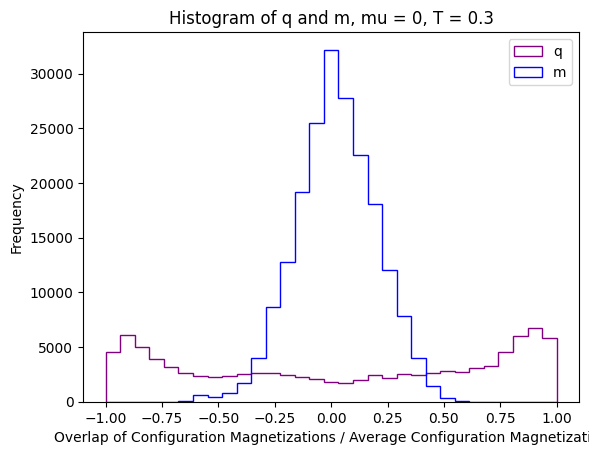

In [406]:
max_seed = 100
m_list, q_list = [], []
N = 30
u = 0
T = 0.3
n_steps = 10000
poll_interval = 10

for seed in range(max_seed):
    Jij = SK_Jij(N, mu=u, seed=seed)
    m, q = SK_Metropolis(N, Jij, T, n_steps, poll_interval)
    m_list.extend(list(i for j in m for i in j))
    q_list.extend(q)

plt.hist(q_list, bins = N+1, range = (-1, 1), histtype='step', label='q', color='purple')
plt.hist(m_list, bins = N+1, range = (-1, 1), histtype='step', label='m', color="blue")
plt.xlabel('Overlap of Configuration Magnetizations / Average Configuration Magnetization')
plt.ylabel('Frequency')
plt.title('Histogram of q and m, mu = 0, T = 0.3')
plt.legend()
plt.show()

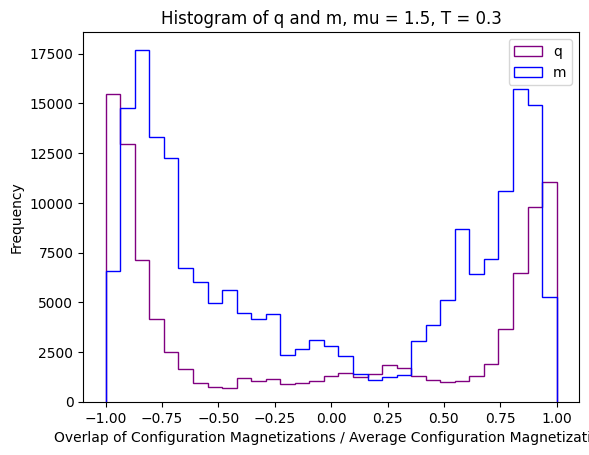

In [407]:
max_seed = 100
m_list, q_list = [], []
N = 30
u = 1.5
T = 0.3
n_steps = 10000
poll_interval = 10

for seed in range(max_seed):
    Jij = SK_Jij(N, mu=u, seed=seed)
    m, q = SK_Metropolis(N, Jij, T, n_steps, poll_interval)
    m_list.extend(list(i for j in m for i in j))
    q_list.extend(q)

plt.hist(q_list, bins = N+1, range = (-1, 1), histtype='step', label='q', color='purple')
plt.hist(m_list, bins = N+1, range = (-1, 1), histtype='step', label='m', color="blue")
plt.xlabel('Overlap of Configuration Magnetizations / Average Configuration Magnetization')
plt.ylabel('Frequency')
plt.title('Histogram of q and m, mu = 1.5, T = 0.3')
plt.legend()
plt.show()

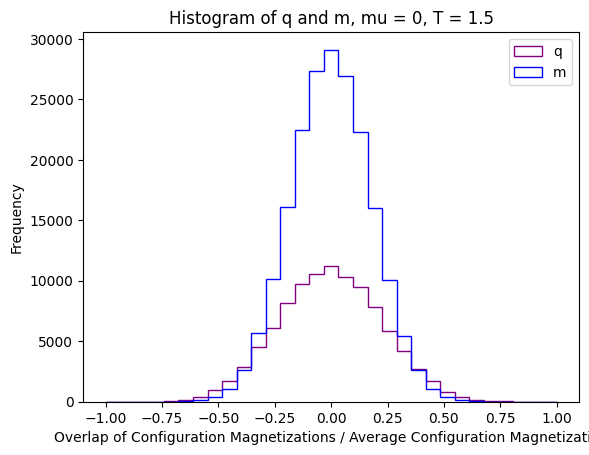

In [408]:
max_seed = 100
m_list, q_list = [], []
N = 30
u = 0
T = 1.5
n_steps = 10000
poll_interval = 10

for seed in range(max_seed):
    Jij = SK_Jij(N, mu=u, seed=seed)
    m, q = SK_Metropolis(N, Jij, T, n_steps, poll_interval)
    m_list.extend(list(i for j in m for i in j))
    q_list.extend(q)

plt.hist(q_list, bins = N+1, range = (-1, 1), histtype='step', label='q', color='purple')
plt.hist(m_list, bins = N+1, range = (-1, 1), histtype='step', label='m', color="blue")
plt.xlabel('Overlap of Configuration Magnetizations / Average Configuration Magnetization')
plt.ylabel('Frequency')
plt.title('Histogram of q and m, mu = 0, T = 1.5')
plt.legend()
plt.show()

## Remarks

* While the Metropolis-Hastings algorithm does produce the correct result in the limit of a very large number of steps, it is fairly slow in its basic form here. There is a large literature of methods for proposing many spin flips together, or running in parallel at many temperatures, to require fewer steps to reach the eventual distribution. Different sweeping and polling procedures are also done. A good exposition of computational methods in statistical physics is *Statistical Mechanics: Algorithms and Computations*, by Werner Krauth.
* Spin glasses have received a lot of attention since the 1970s, culminating in Giorgio Parisi sharing the 2021 Nobel Prize in Physics for his solution for the distribution of the overlap $P(q)$ that we calculated here. Because finding low-energy states of a spin glass is basically a constraint satisfaction problem, spin glasses have deep computer science connections. Some books exploring this are *Spin Glasses and Complexity* by Stein and Newman, *Statistical Physics of Spin Glasses and Information Processing: An Introduction* by Nishimori, and *Information, Physics, and Computation* by Mézard and Montanari.